In [1]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 373.1/373.1 kB 15.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 108.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 21.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 kB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 65.9 MB/s eta 0:00:

In [2]:
import pandas as pd
import numpy as np
import os, re, csv, string, random
import flair
# print(flair.__version__)


import nltk
from nltk.tokenize import RegexpTokenizer

from flair.data import Sentence, Span, Corpus, Dictionary, Token
from flair.embeddings import WordEmbeddings, DocumentPoolEmbeddings, FlairEmbeddings, StackedEmbeddings, TokenEmbeddings
from flair.models import SequenceTagger

from flair.datasets import ColumnCorpus
from flair.trainers import ModelTrainer

from typing import List, Tuple

from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import pickle

from tqdm.auto import tqdm, trange

# import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
# from flair.data import Sentence

In [4]:
from google.colab import drive
drive.mount("/content/drive")

os.chdir('/content/drive/MyDrive/SI 630 project')
# os.listdir('.')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.listdir('datasets/CADEC/CADEC.v2/cadec')


['sct',
 'text',
 'original - unedited version of edited files',
 'meddra - unedited version of edited files',
 'sct - unedited version of edited files',
 'original',
 'meddra']

In [6]:
suf = '_v2'

data_save_dir = 'data'+suf

suf += '_xlm-roberta-large'

In [7]:
meddra_counts = pd.read_csv(data_save_dir+'/meddra_counts.csv')
meddra_counts

,ner,meddra,counts_exploded,counts,counts_exploded_rank
0,Drug,Lipitor,1081,1073,1
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
...,...,...,...,...,...
1294,Finding,Senility,1,1,1233
1295,Drug,Seroquel,1,1,1233
1296,Drug,Solaraze,1,1,1233
1297,Drug,Tagamet,1,1,1233


In [8]:
meddra_counts.loc[meddra_counts.ner == 'ADR',:]

,ner,meddra,counts_exploded,counts,counts_exploded_rank
1,ADR,CONCEPT_LESS,1016,266,2
2,ADR,Severe_pain,722,247,3
3,ADR,Myalgia,619,305,4
4,ADR,Pain,292,260,5
5,ADR,Arthralgia,280,163,6
...,...,...,...,...,...
1268,ADR,Labyrinthitis,1,1,1233
1269,ADR,Dysphagia,1,1,1233
1275,ADR,Lupus_erythematosus,1,1,1233
1278,ADR,Cataract,1,1,1233


In [9]:
with open(data_save_dir+'/cadec_flair_objects.pkl', 'rb') as f:
    docs = pickle.load(f)
docs[:10]

[Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"

In [10]:
len(docs)

1186

In [11]:
temp = docs[0]
temp

Sentence[117]: "i feel a bit drowsy & have a little blurred vision , so far no gastric problems . ive been on arthrotec 50 for over 10 years on and off , only taking it when i needed it . due to my arthritis getting progressively worse , to the point where i am in tears with the agony , gp ' s started me on 75 twice a day and i have to take it . every day for the next month to see how i get on , here goes . so far its been very good , pains almost gone , but i feel a bit weird , didnt have that when on 50 ." → ["i"/O/O, "feel"/O/O, "a"/O/O, "bit"/B-ADR/B-Drowsy, "drowsy"/E-ADR/E-Drowsy, "&"/O/O, "have"/O/O, "a"/O/O, "little"/B-ADR/B-Blurred_vision_-_hazy, "blurred"/I-ADR/I-Blurred_vision_-_hazy, "vision"/E-ADR/E-Blurred_vision_-_hazy, ","/O/O, "so"/O/O, "far"/O/O, "no"/O/O, "gastric"/B-ADR/B-Excessive_upper_gastrointestinal_gas, "problems"/E-ADR/E-Excessive_upper_gastrointestinal_gas, "."/O/O, "ive"/O/O, "been"/O/O, "on"/O/O, "arthrotec"/S-Drug/S-Arthrotec, "50"/O/O, "for"/O/O, "over"/

In [12]:
temp.annotation_layers

{'ner': ['Token[0]: "i"'/'O' (1.0),
  'Token[1]: "feel"'/'O' (1.0),
  'Token[2]: "a"'/'O' (1.0),
  'Token[3]: "bit"'/'B-ADR' (1.0),
  'Token[4]: "drowsy"'/'E-ADR' (1.0),
  'Token[5]: "&"'/'O' (1.0),
  'Token[6]: "have"'/'O' (1.0),
  'Token[7]: "a"'/'O' (1.0),
  'Token[8]: "little"'/'B-ADR' (1.0),
  'Token[9]: "blurred"'/'I-ADR' (1.0),
  'Token[10]: "vision"'/'E-ADR' (1.0),
  'Token[11]: ","'/'O' (1.0),
  'Token[12]: "so"'/'O' (1.0),
  'Token[13]: "far"'/'O' (1.0),
  'Token[14]: "no"'/'O' (1.0),
  'Token[15]: "gastric"'/'B-ADR' (1.0),
  'Token[16]: "problems"'/'E-ADR' (1.0),
  'Token[17]: "."'/'O' (1.0),
  'Token[18]: "ive"'/'O' (1.0),
  'Token[19]: "been"'/'O' (1.0),
  'Token[20]: "on"'/'O' (1.0),
  'Token[21]: "arthrotec"'/'S-Drug' (1.0),
  'Token[22]: "50"'/'O' (1.0),
  'Token[23]: "for"'/'O' (1.0),
  'Token[24]: "over"'/'O' (1.0),
  'Token[25]: "10"'/'O' (1.0),
  'Token[26]: "years"'/'O' (1.0),
  'Token[27]: "on"'/'O' (1.0),
  'Token[28]: "and"'/'O' (1.0),
  'Token[29]: "off"'/'O' (

In [13]:

# define your NER tags
label_dict = {
    'ADR': 'ADR',
    'Drug': 'Drug',
    'Finding': 'Finding',
    'Symptom': 'Symptom',
    'Disease': 'Disease'
}

In [14]:
from flair.data import Corpus
# from flair.datasets import SentenceDataset
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings, TransformerWordEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW, SGD

from flair.visual.training_curves import Plotter
plotter = Plotter()



train_docs, test_docs = train_test_split(docs, test_size=0.2, random_state=321)
dev_docs, test_docs = train_test_split(test_docs, test_size=0.5, random_state=123)

corpus = Corpus(train=train_docs, dev=dev_docs, test=test_docs) # Corpus: 948 train + 119 dev + 119 test sentences
corpus.filter_empty_sentences()
# # create a tag dictionary
labels = ['ADR', 'Drug', 'Finding', 'Symptom', 'Disease']
# tag_dictionary = Dictionary(add_unk=True)
# for label in labels:
#     tag_dictionary.add_item(label)
tag_dictionary = corpus.make_label_dictionary(label_type='ner')
print(tag_dictionary.span_labels)

# create a stacked embedding using GloVe and Flair embeddings
# stacked_embeddings = StackedEmbeddings([
#     WordEmbeddings('glove',
#                    force_cpu=False,
#                 #    embedding_length=1024,
#                   #  fine_tune=True,
#                    ),
#     # TransformerWordEmbeddings('emilyalsentzer/Bio_ClinicalBERT', layers="-1",
#     #                                    subtoken_pooling="first",
#     #                                    is_document_embedding=True,
#     #                                    fine_tune=True,
#     #                                    use_context=True,
#     #                                    max_seq_length=1024,
#     #                                    ),
#     FlairEmbeddings('news-forward',
#                     # fine_tune=True
#                     ),
#     FlairEmbeddings('news-backward',
#                     # fine_tune=True
#                     ),
# ])
# https://github.com/flairNLP/flair/blob/master/resources/docs/embeddings/FLAIR_EMBEDDINGS.md


embeddings = TransformerWordEmbeddings(model='xlm-roberta-large',
                                       layers="-1",
                                       subtoken_pooling="first",
                                       fine_tune=True,
                                       use_context=True,
                                       )

# create a SequenceTagger object and specify the tag dictionary and embeddings to use
tagger = SequenceTagger(hidden_size=256,
                        # embeddings=stacked_embeddings,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type='ner',
                        use_crf=False,
                        use_rnn=False,
                        reproject_embeddings=False,
                        )
tagger.predict_spans = False

print(tagger._determine_if_span_prediction_problem(tagger.label_dictionary))
print(tagger.predict_spans)

# https://github.com/flairNLP/flair/blob/master/flair/trainers/trainer.py
# create a ModelTrainer object and train the tagger
trainer = ModelTrainer(tagger, corpus)

2023-04-21 06:56:19,895 Filtering empty sentences
2023-04-21 06:56:19,947 Corpus: 948 train + 119 dev + 119 test sentences
2023-04-21 06:56:19,949 Computing label dictionary. Progress:


948it [00:00, 6794.01it/s]

2023-04-21 06:56:20,093 Dictionary created for label 'ner' with 22 values: O (seen 79057 times), I-ADR (seen 4449 times), E-ADR (seen 3506 times), B-ADR (seen 3349 times), S-ADR (seen 1363 times), S-Drug (seen 1286 times), B-Finding (seen 200 times), E-Finding (seen 200 times), I-Finding (seen 149 times), B-Disease (seen 119 times), E-Disease (seen 119 times), E-Symptom (seen 114 times), S-Disease (seen 112 times), S-Symptom (seen 112 times), E-Drug (seen 111 times), B-Symptom (seen 110 times), B-Drug (seen 110 times), S-Finding (seen 109 times), I-Symptom (seen 104 times), I-Drug (seen 50 times)
False


2023-04-21 06:57:11,688 SequenceTagger predicts: Dictionary with 22 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-Finding, I-Finding, B-Disease, E-Disease, E-Symptom, S-Disease, S-Symptom, E-Drug, B-Symptom, B-Drug, S-Finding, I-Symptom, I-Drug, I-Disease
True
False


In [15]:
# !tensorboard --logdir=runs
# http://localhost:6006/

In [16]:
hist = trainer.train('flair_ner_model'+suf,
              embeddings_storage_mode='gpu',
              gold_label_dictionary_for_eval=tag_dictionary,
              mini_batch_size = 10,
              eval_batch_size = 10,
              patience=1,
              anneal_factor = 0.5,
              anneal_against_dev_loss=True,
              main_evaluation_metric = ("weighted avg", "f1-score"),
              metrics_for_tensorboard=[("weighted avg", 'precision'), ("weighted avg", 'recall'), ("macro avg", 'f1-score'), ("macro avg", 'precision'), ("macro avg", 'recall')],
              use_tensorboard=True,
              tensorboard_comment='Flair NER',
              tensorboard_log_dir='runs/tb_logs'+suf,
              min_learning_rate=3e-8,
              optimizer=AdamW,
              learning_rate=5.0e-6,
              weight_decay=0.001,
              max_epochs=100,
              monitor_train=True,
              save_optimizer_state=True,)
# hist

2023-04-21 06:57:12,142 tensorboard logging path is runs/tb_logs_v2_transformer


/usr/local/lib/python3.9/dist-packages/flair/trainers/trainer.py:69: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2023-04-21 06:57:12,768 ----------------------------------------------------------------------------------------------------
2023-04-21 06:57:12,772 Model: "SequenceTagger(
  (embeddings): TransformerWordEmbeddings(
    (model): XLMRobertaModel(
      (embeddings): XLMRobertaEmbeddings(
        (word_embeddings): Embedding(250003, 1024)
        (position_embeddings): Embedding(514, 1024, padding_idx=1)
        (token_type_embeddings): Embedding(1, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): XLMRobertaEncoder(
        (layer): ModuleList(
          (0-23): 24 x XLMRobertaLayer(
            (attention): XLMRobertaAttention(
              (self): XLMRobertaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out

100%|██████████| 95/95 [00:22<00:00,  4.19it/s]

2023-04-21 06:58:35,238 Evaluating as a multi-label problem: True


2023-04-21 06:58:38,983 TRAIN : loss 0.4131237268447876 - f1-score (weighted avg)  0.3225


100%|██████████| 12/12 [00:03<00:00,  3.98it/s]


2023-04-21 06:58:42,765 Evaluating as a multi-label problem: False
2023-04-21 06:58:42,832 DEV : loss 0.43227553367614746 - f1-score (weighted avg)  0.2909
2023-04-21 06:58:42,853 BAD EPOCHS (no improvement): 0
2023-04-21 06:58:42,857 saving best model
2023-04-21 06:59:01,485 ----------------------------------------------------------------------------------------------------
2023-04-21 06:59:07,194 epoch 2 - iter 9/95 - loss 0.50615531 - time (sec): 5.71 - samples/sec: 1659.90 - lr: 0.000005
2023-04-21 06:59:12,737 epoch 2 - iter 18/95 - loss 0.48922422 - time (sec): 11.25 - samples/sec: 1625.64 - lr: 0.000005
2023-04-21 06:59:18,134 epoch 2 - iter 27/95 - loss 0.48562147 - time (sec): 16.65 - samples/sec: 1675.00 - lr: 0.000005
2023-04-21 06:59:23,888 epoch 2 - iter 36/95 - loss 0.48285089 - time (sec): 22.40 - samples/sec: 1624.51 - lr: 0.000005
2023-04-21 06:59:28,758 epoch 2 - iter 45/95 - loss 0.48159081 - time (sec): 27.27 - samples/sec: 1628.23 - lr: 0.000005
2023-04-21 06:59:34

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:00:21,145 Evaluating as a multi-label problem: True


2023-04-21 07:00:24,976 TRAIN : loss 0.29493236541748047 - f1-score (weighted avg)  0.5941


100%|██████████| 12/12 [00:03<00:00,  3.89it/s]

2023-04-21 07:00:28,205 Evaluating as a multi-label problem: False
2023-04-21 07:00:28,273 DEV : loss 0.32167720794677734 - f1-score (weighted avg)  0.5615
2023-04-21 07:00:28,293 BAD EPOCHS (no improvement): 0
2023-04-21 07:00:28,297 saving best model


2023-04-21 07:00:48,508 ----------------------------------------------------------------------------------------------------
2023-04-21 07:00:54,235 epoch 3 - iter 9/95 - loss 0.33972984 - time (sec): 5.72 - samples/sec: 1615.63 - lr: 0.000005
2023-04-21 07:00:59,579 epoch 3 - iter 18/95 - loss 0.34712288 - time (sec): 11.07 - samples/sec: 1645.90 - lr: 0.000005
2023-04-21 07:01:04,934 epoch 3 - iter 27/95 - loss 0.35016271 - time (sec): 16.42 - samples/sec: 1647.92 - lr: 0.000005
2023-04-21 07:01:11,164 epoch 3 - iter 36/95 - loss 0.35166682 - time (sec): 22.65 - samples/sec: 1613.07 - lr: 0.000005
2023-04-21 07:01:16,085 epoch 3 - iter 45/95 - loss 0.35134837 - time (sec): 27.57 - samples/sec: 1635.80 - lr: 0.000005
2023-04-21 07:01:21,670 epoch 3 - iter 54/95 - loss 0.34784148 - time (sec): 33.16 - samples/sec: 1626.79 - lr: 0.000005
2023-04-21 07:01:27,427 epoch 3 - iter 63/95 - loss 0.34599351 - time (sec): 38.92 - samples/sec: 1619.52 - lr: 0.000005
2023-04-21 07:01:32,764 epoch 

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:02:08,737 Evaluating as a multi-label problem: True


2023-04-21 07:02:11,462 TRAIN : loss 0.2359333336353302 - f1-score (weighted avg)  0.6721


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

2023-04-21 07:02:14,644 Evaluating as a multi-label problem: False
2023-04-21 07:02:14,716 DEV : loss 0.2743408977985382 - f1-score (weighted avg)  0.6257
2023-04-21 07:02:14,737 BAD EPOCHS (no improvement): 0
2023-04-21 07:02:14,741 saving best model


2023-04-21 07:02:34,735 ----------------------------------------------------------------------------------------------------
2023-04-21 07:02:39,949 epoch 4 - iter 9/95 - loss 0.30563761 - time (sec): 5.21 - samples/sec: 1656.87 - lr: 0.000005
2023-04-21 07:02:45,174 epoch 4 - iter 18/95 - loss 0.31402040 - time (sec): 10.44 - samples/sec: 1627.54 - lr: 0.000005
2023-04-21 07:02:50,769 epoch 4 - iter 27/95 - loss 0.29259127 - time (sec): 16.03 - samples/sec: 1624.89 - lr: 0.000005
2023-04-21 07:02:56,672 epoch 4 - iter 36/95 - loss 0.28179464 - time (sec): 21.93 - samples/sec: 1591.86 - lr: 0.000005
2023-04-21 07:03:03,287 epoch 4 - iter 45/95 - loss 0.29106429 - time (sec): 28.55 - samples/sec: 1552.85 - lr: 0.000005
2023-04-21 07:03:08,628 epoch 4 - iter 54/95 - loss 0.29433911 - time (sec): 33.89 - samples/sec: 1567.76 - lr: 0.000005
2023-04-21 07:03:13,846 epoch 4 - iter 63/95 - loss 0.29618739 - time (sec): 39.11 - samples/sec: 1584.66 - lr: 0.000005
2023-04-21 07:03:19,475 epoch 

100%|██████████| 95/95 [00:22<00:00,  4.31it/s]

2023-04-21 07:03:56,218 Evaluating as a multi-label problem: True


2023-04-21 07:04:00,071 TRAIN : loss 0.21932698786258698 - f1-score (weighted avg)  0.6963


100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

2023-04-21 07:04:03,275 Evaluating as a multi-label problem: False
2023-04-21 07:04:03,343 DEV : loss 0.26840412616729736 - f1-score (weighted avg)  0.6372
2023-04-21 07:04:03,364 BAD EPOCHS (no improvement): 0
2023-04-21 07:04:03,368 saving best model


2023-04-21 07:04:23,358 ----------------------------------------------------------------------------------------------------
2023-04-21 07:04:28,684 epoch 5 - iter 9/95 - loss 0.23953490 - time (sec): 5.32 - samples/sec: 1542.12 - lr: 0.000005
2023-04-21 07:04:34,550 epoch 5 - iter 18/95 - loss 0.25133598 - time (sec): 11.19 - samples/sec: 1694.35 - lr: 0.000005
2023-04-21 07:04:39,811 epoch 5 - iter 27/95 - loss 0.25622697 - time (sec): 16.45 - samples/sec: 1706.66 - lr: 0.000005
2023-04-21 07:04:45,863 epoch 5 - iter 36/95 - loss 0.25547987 - time (sec): 22.50 - samples/sec: 1686.46 - lr: 0.000005
2023-04-21 07:04:50,739 epoch 5 - iter 45/95 - loss 0.25675980 - time (sec): 27.38 - samples/sec: 1727.17 - lr: 0.000005
2023-04-21 07:04:55,501 epoch 5 - iter 54/95 - loss 0.26197625 - time (sec): 32.14 - samples/sec: 1703.45 - lr: 0.000005
2023-04-21 07:05:01,814 epoch 5 - iter 63/95 - loss 0.25923735 - time (sec): 38.45 - samples/sec: 1679.04 - lr: 0.000005
2023-04-21 07:05:07,897 epoch 

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:05:43,019 Evaluating as a multi-label problem: True


2023-04-21 07:05:47,039 TRAIN : loss 0.19356925785541534 - f1-score (weighted avg)  0.7254


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

2023-04-21 07:05:50,215 Evaluating as a multi-label problem: False
2023-04-21 07:05:50,285 DEV : loss 0.25782081484794617 - f1-score (weighted avg)  0.6496
2023-04-21 07:05:50,305 BAD EPOCHS (no improvement): 0
2023-04-21 07:05:50,309 saving best model


2023-04-21 07:06:09,764 ----------------------------------------------------------------------------------------------------
2023-04-21 07:06:15,192 epoch 6 - iter 9/95 - loss 0.22508385 - time (sec): 5.42 - samples/sec: 1682.00 - lr: 0.000005
2023-04-21 07:06:20,290 epoch 6 - iter 18/95 - loss 0.25146872 - time (sec): 10.52 - samples/sec: 1653.55 - lr: 0.000005
2023-04-21 07:06:25,898 epoch 6 - iter 27/95 - loss 0.25125703 - time (sec): 16.13 - samples/sec: 1669.91 - lr: 0.000005
2023-04-21 07:06:31,670 epoch 6 - iter 36/95 - loss 0.23766320 - time (sec): 21.90 - samples/sec: 1653.41 - lr: 0.000005
2023-04-21 07:06:36,663 epoch 6 - iter 45/95 - loss 0.23621596 - time (sec): 26.90 - samples/sec: 1655.55 - lr: 0.000005
2023-04-21 07:06:42,202 epoch 6 - iter 54/95 - loss 0.23067577 - time (sec): 32.43 - samples/sec: 1645.49 - lr: 0.000005
2023-04-21 07:06:48,030 epoch 6 - iter 63/95 - loss 0.22652085 - time (sec): 38.26 - samples/sec: 1651.36 - lr: 0.000005
2023-04-21 07:06:53,374 epoch 

100%|██████████| 95/95 [00:21<00:00,  4.32it/s]

2023-04-21 07:07:30,704 Evaluating as a multi-label problem: True


2023-04-21 07:07:33,432 TRAIN : loss 0.17041897773742676 - f1-score (weighted avg)  0.761


100%|██████████| 12/12 [00:04<00:00,  2.98it/s]

2023-04-21 07:07:37,613 Evaluating as a multi-label problem: False
2023-04-21 07:07:37,689 DEV : loss 0.2543083131313324 - f1-score (weighted avg)  0.6727
2023-04-21 07:07:37,710 BAD EPOCHS (no improvement): 0
2023-04-21 07:07:37,714 saving best model


2023-04-21 07:07:57,678 ----------------------------------------------------------------------------------------------------
2023-04-21 07:08:02,834 epoch 7 - iter 9/95 - loss 0.20445010 - time (sec): 5.15 - samples/sec: 1635.21 - lr: 0.000005
2023-04-21 07:08:09,065 epoch 7 - iter 18/95 - loss 0.21643859 - time (sec): 11.39 - samples/sec: 1575.30 - lr: 0.000005
2023-04-21 07:08:14,342 epoch 7 - iter 27/95 - loss 0.22921659 - time (sec): 16.66 - samples/sec: 1605.86 - lr: 0.000005
2023-04-21 07:08:20,025 epoch 7 - iter 36/95 - loss 0.21999663 - time (sec): 22.34 - samples/sec: 1617.25 - lr: 0.000005
2023-04-21 07:08:25,478 epoch 7 - iter 45/95 - loss 0.21824463 - time (sec): 27.80 - samples/sec: 1637.07 - lr: 0.000005
2023-04-21 07:08:31,874 epoch 7 - iter 54/95 - loss 0.21045341 - time (sec): 34.19 - samples/sec: 1629.21 - lr: 0.000005
2023-04-21 07:08:37,166 epoch 7 - iter 63/95 - loss 0.21040409 - time (sec): 39.49 - samples/sec: 1603.54 - lr: 0.000005
2023-04-21 07:08:42,709 epoch 

100%|██████████| 95/95 [00:22<00:00,  4.31it/s]

2023-04-21 07:09:18,922 Evaluating as a multi-label problem: True


2023-04-21 07:09:22,778 TRAIN : loss 0.15869013965129852 - f1-score (weighted avg)  0.7754


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]

2023-04-21 07:09:25,970 Evaluating as a multi-label problem: False
2023-04-21 07:09:26,038 DEV : loss 0.25603732466697693 - f1-score (weighted avg)  0.6784
2023-04-21 07:09:26,059 BAD EPOCHS (no improvement): 1
2023-04-21 07:09:26,063 ----------------------------------------------------------------------------------------------------


2023-04-21 07:09:31,781 epoch 8 - iter 9/95 - loss 0.19727700 - time (sec): 5.72 - samples/sec: 1560.28 - lr: 0.000005
2023-04-21 07:09:37,116 epoch 8 - iter 18/95 - loss 0.19322846 - time (sec): 11.05 - samples/sec: 1592.49 - lr: 0.000005
2023-04-21 07:09:42,515 epoch 8 - iter 27/95 - loss 0.18919846 - time (sec): 16.45 - samples/sec: 1591.29 - lr: 0.000005
2023-04-21 07:09:48,379 epoch 8 - iter 36/95 - loss 0.19688976 - time (sec): 22.31 - samples/sec: 1590.67 - lr: 0.000005
2023-04-21 07:09:53,373 epoch 8 - iter 45/95 - loss 0.19888562 - time (sec): 27.31 - samples/sec: 1602.81 - lr: 0.000005
2023-04-21 07:09:59,001 epoch 8 - iter 54/95 - loss 0.19436060 - time (sec): 32.94 - samples/sec: 1589.68 - lr: 0.000005
2023-04-21 07:10:04,369 epoch 8 - iter 63/95 - loss 0.20080812 - time (sec): 38.30 - samples/sec: 1583.23 - lr: 0.000005
2023-04-21 07:10:09,977 epoch 8 - iter 72/95 - loss 0.20349020 - time (sec): 43.91 - samples/sec: 1596.97 - lr: 0.000005
2023-04-21 07:10:15,725 epoch 8 - 

100%|██████████| 95/95 [00:22<00:00,  4.32it/s]

2023-04-21 07:10:46,482 Evaluating as a multi-label problem: True


2023-04-21 07:10:50,357 TRAIN : loss 0.14811904728412628 - f1-score (weighted avg)  0.7898


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

2023-04-21 07:10:53,533 Evaluating as a multi-label problem: False
2023-04-21 07:10:53,602 DEV : loss 0.26694801449775696 - f1-score (weighted avg)  0.6872
2023-04-21 07:10:53,621 Epoch     8: reducing learning rate of group 0 to 2.5000e-06.
2023-04-21 07:10:53,623 BAD EPOCHS (no improvement): 2
2023-04-21 07:10:53,627 ----------------------------------------------------------------------------------------------------


2023-04-21 07:10:59,403 epoch 9 - iter 9/95 - loss 0.16636702 - time (sec): 5.78 - samples/sec: 1737.47 - lr: 0.000003
2023-04-21 07:11:04,555 epoch 9 - iter 18/95 - loss 0.15714943 - time (sec): 10.93 - samples/sec: 1794.24 - lr: 0.000003
2023-04-21 07:11:10,552 epoch 9 - iter 27/95 - loss 0.15642907 - time (sec): 16.92 - samples/sec: 1752.35 - lr: 0.000003
2023-04-21 07:11:16,046 epoch 9 - iter 36/95 - loss 0.16099000 - time (sec): 22.42 - samples/sec: 1727.14 - lr: 0.000003
2023-04-21 07:11:21,747 epoch 9 - iter 45/95 - loss 0.16809787 - time (sec): 28.12 - samples/sec: 1704.56 - lr: 0.000003
2023-04-21 07:11:26,822 epoch 9 - iter 54/95 - loss 0.17582250 - time (sec): 33.19 - samples/sec: 1677.05 - lr: 0.000003
2023-04-21 07:11:30,988 epoch 9 - iter 63/95 - loss 0.17715260 - time (sec): 37.36 - samples/sec: 1666.88 - lr: 0.000003
2023-04-21 07:11:36,680 epoch 9 - iter 72/95 - loss 0.17740371 - time (sec): 43.05 - samples/sec: 1651.68 - lr: 0.000003
2023-04-21 07:11:41,764 epoch 9 - 

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:12:12,832 Evaluating as a multi-label problem: True


2023-04-21 07:12:16,752 TRAIN : loss 0.13000380992889404 - f1-score (weighted avg)  0.8153


100%|██████████| 12/12 [00:03<00:00,  3.97it/s]

2023-04-21 07:12:19,923 Evaluating as a multi-label problem: False
2023-04-21 07:12:19,991 DEV : loss 0.26449358463287354 - f1-score (weighted avg)  0.6901
2023-04-21 07:12:20,011 BAD EPOCHS (no improvement): 1
2023-04-21 07:12:20,015 ----------------------------------------------------------------------------------------------------


2023-04-21 07:12:25,451 epoch 10 - iter 9/95 - loss 0.17729608 - time (sec): 5.43 - samples/sec: 1771.41 - lr: 0.000003
2023-04-21 07:12:30,695 epoch 10 - iter 18/95 - loss 0.18015182 - time (sec): 10.68 - samples/sec: 1654.19 - lr: 0.000003
2023-04-21 07:12:36,645 epoch 10 - iter 27/95 - loss 0.17144173 - time (sec): 16.63 - samples/sec: 1645.75 - lr: 0.000003
2023-04-21 07:12:42,388 epoch 10 - iter 36/95 - loss 0.16962831 - time (sec): 22.37 - samples/sec: 1596.00 - lr: 0.000003
2023-04-21 07:12:48,775 epoch 10 - iter 45/95 - loss 0.16118857 - time (sec): 28.76 - samples/sec: 1575.58 - lr: 0.000003
2023-04-21 07:12:54,211 epoch 10 - iter 54/95 - loss 0.16259931 - time (sec): 34.20 - samples/sec: 1604.27 - lr: 0.000003
2023-04-21 07:12:59,132 epoch 10 - iter 63/95 - loss 0.16226631 - time (sec): 39.12 - samples/sec: 1610.64 - lr: 0.000003
2023-04-21 07:13:04,357 epoch 10 - iter 72/95 - loss 0.16552963 - time (sec): 44.34 - samples/sec: 1612.79 - lr: 0.000003
2023-04-21 07:13:09,273 ep

100%|██████████| 95/95 [00:21<00:00,  4.34it/s]

2023-04-21 07:13:39,323 Evaluating as a multi-label problem: True


2023-04-21 07:13:42,054 TRAIN : loss 0.11832153052091599 - f1-score (weighted avg)  0.8286


100%|██████████| 12/12 [00:03<00:00,  3.94it/s]


2023-04-21 07:13:46,237 Evaluating as a multi-label problem: False
2023-04-21 07:13:46,306 DEV : loss 0.2546929717063904 - f1-score (weighted avg)  0.6902
2023-04-21 07:13:46,326 Epoch    10: reducing learning rate of group 0 to 1.2500e-06.
2023-04-21 07:13:46,328 BAD EPOCHS (no improvement): 2
2023-04-21 07:13:46,331 ----------------------------------------------------------------------------------------------------
2023-04-21 07:13:51,510 epoch 11 - iter 9/95 - loss 0.14451168 - time (sec): 5.18 - samples/sec: 1643.15 - lr: 0.000001
2023-04-21 07:13:57,033 epoch 11 - iter 18/95 - loss 0.14821641 - time (sec): 10.70 - samples/sec: 1651.57 - lr: 0.000001
2023-04-21 07:14:01,892 epoch 11 - iter 27/95 - loss 0.15197228 - time (sec): 15.56 - samples/sec: 1686.68 - lr: 0.000001
2023-04-21 07:14:07,638 epoch 11 - iter 36/95 - loss 0.14637132 - time (sec): 21.30 - samples/sec: 1719.47 - lr: 0.000001
2023-04-21 07:14:13,190 epoch 11 - iter 45/95 - loss 0.15072547 - time (sec): 26.86 - samples

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:15:06,206 Evaluating as a multi-label problem: True


2023-04-21 07:15:10,065 TRAIN : loss 0.11708444356918335 - f1-score (weighted avg)  0.8338


100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

2023-04-21 07:15:13,272 Evaluating as a multi-label problem: False
2023-04-21 07:15:13,351 DEV : loss 0.2686716914176941 - f1-score (weighted avg)  0.6932
2023-04-21 07:15:13,373 BAD EPOCHS (no improvement): 1
2023-04-21 07:15:13,378 ----------------------------------------------------------------------------------------------------


2023-04-21 07:15:18,531 epoch 12 - iter 9/95 - loss 0.17131934 - time (sec): 5.15 - samples/sec: 1716.82 - lr: 0.000001
2023-04-21 07:15:24,103 epoch 12 - iter 18/95 - loss 0.15632184 - time (sec): 10.72 - samples/sec: 1719.50 - lr: 0.000001
2023-04-21 07:15:29,152 epoch 12 - iter 27/95 - loss 0.14816569 - time (sec): 15.77 - samples/sec: 1689.65 - lr: 0.000001
2023-04-21 07:15:34,923 epoch 12 - iter 36/95 - loss 0.14584519 - time (sec): 21.54 - samples/sec: 1675.10 - lr: 0.000001
2023-04-21 07:15:40,277 epoch 12 - iter 45/95 - loss 0.14471520 - time (sec): 26.90 - samples/sec: 1648.87 - lr: 0.000001
2023-04-21 07:15:45,977 epoch 12 - iter 54/95 - loss 0.14931201 - time (sec): 32.60 - samples/sec: 1631.87 - lr: 0.000001
2023-04-21 07:15:51,353 epoch 12 - iter 63/95 - loss 0.15007939 - time (sec): 37.97 - samples/sec: 1662.98 - lr: 0.000001
2023-04-21 07:15:56,880 epoch 12 - iter 72/95 - loss 0.14930329 - time (sec): 43.50 - samples/sec: 1661.43 - lr: 0.000001
2023-04-21 07:16:01,886 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:16:32,677 Evaluating as a multi-label problem: True


2023-04-21 07:16:36,621 TRAIN : loss 0.10720328986644745 - f1-score (weighted avg)  0.8459


100%|██████████| 12/12 [00:03<00:00,  3.94it/s]

2023-04-21 07:16:39,820 Evaluating as a multi-label problem: False
2023-04-21 07:16:39,889 DEV : loss 0.2666051685810089 - f1-score (weighted avg)  0.6893
2023-04-21 07:16:39,909 Epoch    12: reducing learning rate of group 0 to 6.2500e-07.
2023-04-21 07:16:39,911 BAD EPOCHS (no improvement): 2
2023-04-21 07:16:39,914 ----------------------------------------------------------------------------------------------------


2023-04-21 07:16:45,459 epoch 13 - iter 9/95 - loss 0.16478931 - time (sec): 5.54 - samples/sec: 1630.11 - lr: 0.000001
2023-04-21 07:16:51,531 epoch 13 - iter 18/95 - loss 0.15212684 - time (sec): 11.62 - samples/sec: 1588.46 - lr: 0.000001
2023-04-21 07:16:56,649 epoch 13 - iter 27/95 - loss 0.15242407 - time (sec): 16.73 - samples/sec: 1533.57 - lr: 0.000001
2023-04-21 07:17:02,377 epoch 13 - iter 36/95 - loss 0.14323837 - time (sec): 22.46 - samples/sec: 1616.37 - lr: 0.000001
2023-04-21 07:17:08,085 epoch 13 - iter 45/95 - loss 0.14264204 - time (sec): 28.17 - samples/sec: 1633.61 - lr: 0.000001
2023-04-21 07:17:13,850 epoch 13 - iter 54/95 - loss 0.14114411 - time (sec): 33.93 - samples/sec: 1630.39 - lr: 0.000001
2023-04-21 07:17:19,345 epoch 13 - iter 63/95 - loss 0.13907258 - time (sec): 39.43 - samples/sec: 1633.33 - lr: 0.000001
2023-04-21 07:17:24,701 epoch 13 - iter 72/95 - loss 0.13953599 - time (sec): 44.79 - samples/sec: 1628.59 - lr: 0.000001
2023-04-21 07:17:30,012 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:18:00,409 Evaluating as a multi-label problem: True


2023-04-21 07:18:03,115 TRAIN : loss 0.10769189894199371 - f1-score (weighted avg)  0.8439


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


2023-04-21 07:18:07,305 Evaluating as a multi-label problem: False
2023-04-21 07:18:07,374 DEV : loss 0.27092432975769043 - f1-score (weighted avg)  0.6956
2023-04-21 07:18:07,394 BAD EPOCHS (no improvement): 1
2023-04-21 07:18:07,405 ----------------------------------------------------------------------------------------------------
2023-04-21 07:18:13,072 epoch 14 - iter 9/95 - loss 0.12172698 - time (sec): 5.67 - samples/sec: 1546.24 - lr: 0.000001
2023-04-21 07:18:18,226 epoch 14 - iter 18/95 - loss 0.13343244 - time (sec): 10.82 - samples/sec: 1595.00 - lr: 0.000001
2023-04-21 07:18:24,248 epoch 14 - iter 27/95 - loss 0.12324797 - time (sec): 16.84 - samples/sec: 1630.58 - lr: 0.000001
2023-04-21 07:18:29,926 epoch 14 - iter 36/95 - loss 0.13198821 - time (sec): 22.52 - samples/sec: 1627.37 - lr: 0.000001
2023-04-21 07:18:34,870 epoch 14 - iter 45/95 - loss 0.13466269 - time (sec): 27.46 - samples/sec: 1655.84 - lr: 0.000001
2023-04-21 07:18:39,945 epoch 14 - iter 54/95 - loss 0.1

100%|██████████| 95/95 [00:21<00:00,  4.34it/s]

2023-04-21 07:19:27,929 Evaluating as a multi-label problem: True


2023-04-21 07:19:31,804 TRAIN : loss 0.10326381027698517 - f1-score (weighted avg)  0.85


100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

2023-04-21 07:19:35,018 Evaluating as a multi-label problem: False
2023-04-21 07:19:35,088 DEV : loss 0.2704702615737915 - f1-score (weighted avg)  0.6922
2023-04-21 07:19:35,108 Epoch    14: reducing learning rate of group 0 to 3.1250e-07.
2023-04-21 07:19:35,110 BAD EPOCHS (no improvement): 2
2023-04-21 07:19:35,114 ----------------------------------------------------------------------------------------------------


2023-04-21 07:19:40,318 epoch 15 - iter 9/95 - loss 0.14075208 - time (sec): 5.20 - samples/sec: 1605.47 - lr: 0.000000
2023-04-21 07:19:45,834 epoch 15 - iter 18/95 - loss 0.13328283 - time (sec): 10.72 - samples/sec: 1715.64 - lr: 0.000000
2023-04-21 07:19:51,070 epoch 15 - iter 27/95 - loss 0.13837990 - time (sec): 15.95 - samples/sec: 1701.86 - lr: 0.000000
2023-04-21 07:19:56,729 epoch 15 - iter 36/95 - loss 0.13618612 - time (sec): 21.61 - samples/sec: 1681.97 - lr: 0.000000
2023-04-21 07:20:01,991 epoch 15 - iter 45/95 - loss 0.13356997 - time (sec): 26.88 - samples/sec: 1670.84 - lr: 0.000000
2023-04-21 07:20:07,478 epoch 15 - iter 54/95 - loss 0.13229546 - time (sec): 32.36 - samples/sec: 1651.82 - lr: 0.000000
2023-04-21 07:20:13,131 epoch 15 - iter 63/95 - loss 0.13493891 - time (sec): 38.02 - samples/sec: 1647.44 - lr: 0.000000
2023-04-21 07:20:18,464 epoch 15 - iter 72/95 - loss 0.13752786 - time (sec): 43.35 - samples/sec: 1638.03 - lr: 0.000000
2023-04-21 07:20:23,669 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:20:54,089 Evaluating as a multi-label problem: True


2023-04-21 07:20:58,170 TRAIN : loss 0.10196240246295929 - f1-score (weighted avg)  0.853


100%|██████████| 12/12 [00:03<00:00,  3.94it/s]

2023-04-21 07:21:01,363 Evaluating as a multi-label problem: False
2023-04-21 07:21:01,433 DEV : loss 0.2712968587875366 - f1-score (weighted avg)  0.693
2023-04-21 07:21:01,453 BAD EPOCHS (no improvement): 1
2023-04-21 07:21:01,457 ----------------------------------------------------------------------------------------------------


2023-04-21 07:21:06,363 epoch 16 - iter 9/95 - loss 0.15086616 - time (sec): 4.90 - samples/sec: 1681.62 - lr: 0.000000
2023-04-21 07:21:12,526 epoch 16 - iter 18/95 - loss 0.14424629 - time (sec): 11.07 - samples/sec: 1645.48 - lr: 0.000000
2023-04-21 07:21:18,644 epoch 16 - iter 27/95 - loss 0.13878342 - time (sec): 17.19 - samples/sec: 1656.55 - lr: 0.000000
2023-04-21 07:21:24,110 epoch 16 - iter 36/95 - loss 0.13789251 - time (sec): 22.65 - samples/sec: 1650.07 - lr: 0.000000
2023-04-21 07:21:29,274 epoch 16 - iter 45/95 - loss 0.13746768 - time (sec): 27.82 - samples/sec: 1653.31 - lr: 0.000000
2023-04-21 07:21:35,086 epoch 16 - iter 54/95 - loss 0.13265111 - time (sec): 33.63 - samples/sec: 1661.40 - lr: 0.000000
2023-04-21 07:21:40,555 epoch 16 - iter 63/95 - loss 0.13800288 - time (sec): 39.10 - samples/sec: 1614.37 - lr: 0.000000
2023-04-21 07:21:46,491 epoch 16 - iter 72/95 - loss 0.13930921 - time (sec): 45.03 - samples/sec: 1611.06 - lr: 0.000000
2023-04-21 07:21:51,870 ep

100%|██████████| 95/95 [00:21<00:00,  4.35it/s]

2023-04-21 07:22:21,904 Evaluating as a multi-label problem: True


2023-04-21 07:22:24,613 TRAIN : loss 0.10105723142623901 - f1-score (weighted avg)  0.8545


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


2023-04-21 07:22:28,801 Evaluating as a multi-label problem: False
2023-04-21 07:22:28,870 DEV : loss 0.27236244082450867 - f1-score (weighted avg)  0.6956
2023-04-21 07:22:28,890 Epoch    16: reducing learning rate of group 0 to 1.5625e-07.
2023-04-21 07:22:28,892 BAD EPOCHS (no improvement): 2
2023-04-21 07:22:28,895 ----------------------------------------------------------------------------------------------------
2023-04-21 07:22:34,154 epoch 17 - iter 9/95 - loss 0.13477091 - time (sec): 5.26 - samples/sec: 1487.51 - lr: 0.000000
2023-04-21 07:22:39,740 epoch 17 - iter 18/95 - loss 0.13444610 - time (sec): 10.84 - samples/sec: 1547.13 - lr: 0.000000
2023-04-21 07:22:44,957 epoch 17 - iter 27/95 - loss 0.13496790 - time (sec): 16.06 - samples/sec: 1580.64 - lr: 0.000000
2023-04-21 07:22:50,004 epoch 17 - iter 36/95 - loss 0.13416131 - time (sec): 21.11 - samples/sec: 1616.44 - lr: 0.000000
2023-04-21 07:22:55,590 epoch 17 - iter 45/95 - loss 0.13241109 - time (sec): 26.69 - sample

100%|██████████| 95/95 [00:21<00:00,  4.35it/s]

2023-04-21 07:23:48,616 Evaluating as a multi-label problem: True


2023-04-21 07:23:52,491 TRAIN : loss 0.10119921714067459 - f1-score (weighted avg)  0.8546


100%|██████████| 12/12 [00:03<00:00,  3.90it/s]

2023-04-21 07:23:55,716 Evaluating as a multi-label problem: False
2023-04-21 07:23:55,786 DEV : loss 0.27388402819633484 - f1-score (weighted avg)  0.6977
2023-04-21 07:23:55,806 BAD EPOCHS (no improvement): 1
2023-04-21 07:23:55,810 ----------------------------------------------------------------------------------------------------


2023-04-21 07:24:01,330 epoch 18 - iter 9/95 - loss 0.13270085 - time (sec): 5.52 - samples/sec: 1672.94 - lr: 0.000000
2023-04-21 07:24:07,417 epoch 18 - iter 18/95 - loss 0.13715185 - time (sec): 11.61 - samples/sec: 1667.68 - lr: 0.000000
2023-04-21 07:24:12,942 epoch 18 - iter 27/95 - loss 0.14095364 - time (sec): 17.13 - samples/sec: 1638.23 - lr: 0.000000
2023-04-21 07:24:18,351 epoch 18 - iter 36/95 - loss 0.13845659 - time (sec): 22.54 - samples/sec: 1626.72 - lr: 0.000000
2023-04-21 07:24:24,103 epoch 18 - iter 45/95 - loss 0.13806565 - time (sec): 28.29 - samples/sec: 1598.55 - lr: 0.000000
2023-04-21 07:24:29,444 epoch 18 - iter 54/95 - loss 0.13547245 - time (sec): 33.63 - samples/sec: 1617.38 - lr: 0.000000
2023-04-21 07:24:34,983 epoch 18 - iter 63/95 - loss 0.13461914 - time (sec): 39.17 - samples/sec: 1604.71 - lr: 0.000000
2023-04-21 07:24:40,963 epoch 18 - iter 72/95 - loss 0.13362146 - time (sec): 45.15 - samples/sec: 1615.28 - lr: 0.000000
2023-04-21 07:24:46,350 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:25:16,995 Evaluating as a multi-label problem: True


2023-04-21 07:25:20,935 TRAIN : loss 0.09984735399484634 - f1-score (weighted avg)  0.856


100%|██████████| 12/12 [00:03<00:00,  3.92it/s]

2023-04-21 07:25:24,148 Evaluating as a multi-label problem: False
2023-04-21 07:25:24,217 DEV : loss 0.27410396933555603 - f1-score (weighted avg)  0.6988
2023-04-21 07:25:24,238 Epoch    18: reducing learning rate of group 0 to 7.8125e-08.
2023-04-21 07:25:24,240 BAD EPOCHS (no improvement): 2
2023-04-21 07:25:24,243 ----------------------------------------------------------------------------------------------------


2023-04-21 07:25:29,721 epoch 19 - iter 9/95 - loss 0.12533697 - time (sec): 5.48 - samples/sec: 1903.79 - lr: 0.000000
2023-04-21 07:25:35,690 epoch 19 - iter 18/95 - loss 0.14321046 - time (sec): 11.44 - samples/sec: 1710.99 - lr: 0.000000
2023-04-21 07:25:41,015 epoch 19 - iter 27/95 - loss 0.14519383 - time (sec): 16.77 - samples/sec: 1644.76 - lr: 0.000000
2023-04-21 07:25:46,893 epoch 19 - iter 36/95 - loss 0.14391936 - time (sec): 22.65 - samples/sec: 1616.72 - lr: 0.000000
2023-04-21 07:25:52,060 epoch 19 - iter 45/95 - loss 0.14417416 - time (sec): 27.82 - samples/sec: 1623.79 - lr: 0.000000
2023-04-21 07:25:57,360 epoch 19 - iter 54/95 - loss 0.14170297 - time (sec): 33.11 - samples/sec: 1651.01 - lr: 0.000000
2023-04-21 07:26:02,470 epoch 19 - iter 63/95 - loss 0.14040375 - time (sec): 38.23 - samples/sec: 1647.95 - lr: 0.000000
2023-04-21 07:26:07,814 epoch 19 - iter 72/95 - loss 0.13921835 - time (sec): 43.57 - samples/sec: 1645.61 - lr: 0.000000
2023-04-21 07:26:13,743 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:26:43,980 Evaluating as a multi-label problem: True


2023-04-21 07:26:46,700 TRAIN : loss 0.09979742765426636 - f1-score (weighted avg)  0.8559


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]

2023-04-21 07:26:49,878 Evaluating as a multi-label problem: False
2023-04-21 07:26:49,946 DEV : loss 0.27468565106391907 - f1-score (weighted avg)  0.6983
2023-04-21 07:26:49,966 BAD EPOCHS (no improvement): 1
2023-04-21 07:26:49,970 ----------------------------------------------------------------------------------------------------


2023-04-21 07:26:55,250 epoch 20 - iter 9/95 - loss 0.13894820 - time (sec): 5.28 - samples/sec: 1653.68 - lr: 0.000000
2023-04-21 07:27:00,614 epoch 20 - iter 18/95 - loss 0.14063536 - time (sec): 10.64 - samples/sec: 1630.44 - lr: 0.000000
2023-04-21 07:27:05,801 epoch 20 - iter 27/95 - loss 0.14013693 - time (sec): 15.83 - samples/sec: 1687.08 - lr: 0.000000
2023-04-21 07:27:10,635 epoch 20 - iter 36/95 - loss 0.13514892 - time (sec): 20.66 - samples/sec: 1671.34 - lr: 0.000000
2023-04-21 07:27:17,249 epoch 20 - iter 45/95 - loss 0.13339199 - time (sec): 27.28 - samples/sec: 1616.63 - lr: 0.000000
2023-04-21 07:27:23,502 epoch 20 - iter 54/95 - loss 0.12912216 - time (sec): 33.53 - samples/sec: 1636.92 - lr: 0.000000
2023-04-21 07:27:28,538 epoch 20 - iter 63/95 - loss 0.13125534 - time (sec): 38.57 - samples/sec: 1631.58 - lr: 0.000000
2023-04-21 07:27:33,870 epoch 20 - iter 72/95 - loss 0.13194652 - time (sec): 43.90 - samples/sec: 1630.97 - lr: 0.000000
2023-04-21 07:27:40,335 ep

100%|██████████| 95/95 [00:21<00:00,  4.34it/s]

2023-04-21 07:28:10,759 Evaluating as a multi-label problem: True


2023-04-21 07:28:14,640 TRAIN : loss 0.10002043843269348 - f1-score (weighted avg)  0.8556


100%|██████████| 12/12 [00:03<00:00,  3.93it/s]

2023-04-21 07:28:17,849 Evaluating as a multi-label problem: False
2023-04-21 07:28:17,920 DEV : loss 0.275593101978302 - f1-score (weighted avg)  0.6974
2023-04-21 07:28:17,940 Epoch    20: reducing learning rate of group 0 to 3.9063e-08.
2023-04-21 07:28:17,942 BAD EPOCHS (no improvement): 2
2023-04-21 07:28:17,945 ----------------------------------------------------------------------------------------------------


2023-04-21 07:28:22,979 epoch 21 - iter 9/95 - loss 0.13453530 - time (sec): 5.03 - samples/sec: 1773.61 - lr: 0.000000
2023-04-21 07:28:28,322 epoch 21 - iter 18/95 - loss 0.12935095 - time (sec): 10.37 - samples/sec: 1703.62 - lr: 0.000000
2023-04-21 07:28:33,959 epoch 21 - iter 27/95 - loss 0.12478924 - time (sec): 16.01 - samples/sec: 1712.58 - lr: 0.000000
2023-04-21 07:28:39,968 epoch 21 - iter 36/95 - loss 0.12839764 - time (sec): 22.02 - samples/sec: 1677.48 - lr: 0.000000
2023-04-21 07:28:45,053 epoch 21 - iter 45/95 - loss 0.12754474 - time (sec): 27.11 - samples/sec: 1684.12 - lr: 0.000000
2023-04-21 07:28:50,152 epoch 21 - iter 54/95 - loss 0.12644125 - time (sec): 32.20 - samples/sec: 1674.12 - lr: 0.000000
2023-04-21 07:28:55,559 epoch 21 - iter 63/95 - loss 0.12803107 - time (sec): 37.61 - samples/sec: 1673.87 - lr: 0.000000
2023-04-21 07:29:01,333 epoch 21 - iter 72/95 - loss 0.12682842 - time (sec): 43.39 - samples/sec: 1663.61 - lr: 0.000000
2023-04-21 07:29:06,460 ep

100%|██████████| 95/95 [00:21<00:00,  4.34it/s]

2023-04-21 07:29:36,667 Evaluating as a multi-label problem: True


2023-04-21 07:29:40,578 TRAIN : loss 0.10026019811630249 - f1-score (weighted avg)  0.8559


100%|██████████| 12/12 [00:03<00:00,  3.96it/s]

2023-04-21 07:29:43,757 Evaluating as a multi-label problem: False
2023-04-21 07:29:43,825 DEV : loss 0.2759714424610138 - f1-score (weighted avg)  0.6954
2023-04-21 07:29:43,845 BAD EPOCHS (no improvement): 1
2023-04-21 07:29:43,850 ----------------------------------------------------------------------------------------------------


2023-04-21 07:29:49,797 epoch 22 - iter 9/95 - loss 0.13184655 - time (sec): 5.95 - samples/sec: 1630.57 - lr: 0.000000
2023-04-21 07:29:55,180 epoch 22 - iter 18/95 - loss 0.14376210 - time (sec): 11.33 - samples/sec: 1522.40 - lr: 0.000000
2023-04-21 07:30:00,548 epoch 22 - iter 27/95 - loss 0.14505086 - time (sec): 16.70 - samples/sec: 1498.77 - lr: 0.000000
2023-04-21 07:30:06,324 epoch 22 - iter 36/95 - loss 0.13672661 - time (sec): 22.47 - samples/sec: 1537.82 - lr: 0.000000
2023-04-21 07:30:11,321 epoch 22 - iter 45/95 - loss 0.13635902 - time (sec): 27.47 - samples/sec: 1556.04 - lr: 0.000000
2023-04-21 07:30:17,121 epoch 22 - iter 54/95 - loss 0.13400335 - time (sec): 33.27 - samples/sec: 1579.03 - lr: 0.000000
2023-04-21 07:30:22,484 epoch 22 - iter 63/95 - loss 0.13498355 - time (sec): 38.63 - samples/sec: 1597.80 - lr: 0.000000
2023-04-21 07:30:28,548 epoch 22 - iter 72/95 - loss 0.13374533 - time (sec): 44.70 - samples/sec: 1599.79 - lr: 0.000000
2023-04-21 07:30:33,468 ep

100%|██████████| 95/95 [00:21<00:00,  4.33it/s]

2023-04-21 07:31:04,381 Evaluating as a multi-label problem: True


2023-04-21 07:31:07,107 TRAIN : loss 0.09985252469778061 - f1-score (weighted avg)  0.8565


100%|██████████| 12/12 [00:03<00:00,  3.95it/s]


2023-04-21 07:31:11,310 Evaluating as a multi-label problem: False
2023-04-21 07:31:11,379 DEV : loss 0.27577492594718933 - f1-score (weighted avg)  0.6964
2023-04-21 07:31:11,399 Epoch    22: reducing learning rate of group 0 to 1.9531e-08.
2023-04-21 07:31:11,401 BAD EPOCHS (no improvement): 2
2023-04-21 07:31:11,404 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:11,406 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:11,408 learning rate too small - quitting training!
2023-04-21 07:31:11,409 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:29,926 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:52,311 SequenceTagger predicts: Dictionary with 22 tags: <unk>, O, I-ADR, E-ADR, B-ADR, S-ADR, S-Drug, B-Finding, E-F

100%|██████████| 12/12 [00:03<00:00,  3.68it/s]

2023-04-21 07:31:56,485 Evaluating as a multi-label problem: True


2023-04-21 07:31:56,821 0.732	0.732	0.732	0.9328
2023-04-21 07:31:56,823 
Results:
- F-score (micro) 0.732
- F-score (macro) 0.296
- Accuracy 0.9328

By class:
              precision    recall  f1-score   support

       I-ADR     0.6755    0.7295    0.7015       525
       E-ADR     0.7840    0.8620    0.8211       442
       B-ADR     0.7484    0.8469    0.7946       418
      S-Drug     0.8571    0.9688    0.9095       192
       S-ADR     0.7041    0.7532    0.7278       158
      B-Drug     0.6000    0.3333    0.4286        27
   E-Finding     0.4286    0.2222    0.2927        27
      E-Drug     0.8000    0.2963    0.4324        27
   B-Disease     0.2000    0.6250    0.3030         8
   B-Finding     0.1429    0.0417    0.0645        24
   S-Finding     0.0000    0.0000    0.0000        28
      I-Drug     0.0000    0.0000    0.0000        25
   I-Symptom     0.0000    0.0000    0.0000        20
   S-Disease     0.6667    0.3333    0.4444        12
   B-Symptom     0.0000    0.

In [17]:
# print(hist.keys())
# hist

_v2_transformer
2023-04-21 07:31:56,848 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:56,850 WARNING: No LOSS found for test split in this data.
2023-04-21 07:31:56,851 Are you sure you want to plot LOSS and not another value?
2023-04-21 07:31:56,852 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:56,876 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:56,877 WARNING: No F1 found for test split in this data.
2023-04-21 07:31:56,878 Are you sure you want to plot F1 and not another value?
2023-04-21 07:31:56,880 ----------------------------------------------------------------------------------------------------
2023-04-21 07:31:57,931 Loss and F1 plots are saved in flair_ner_model_v2_transformer/training.png


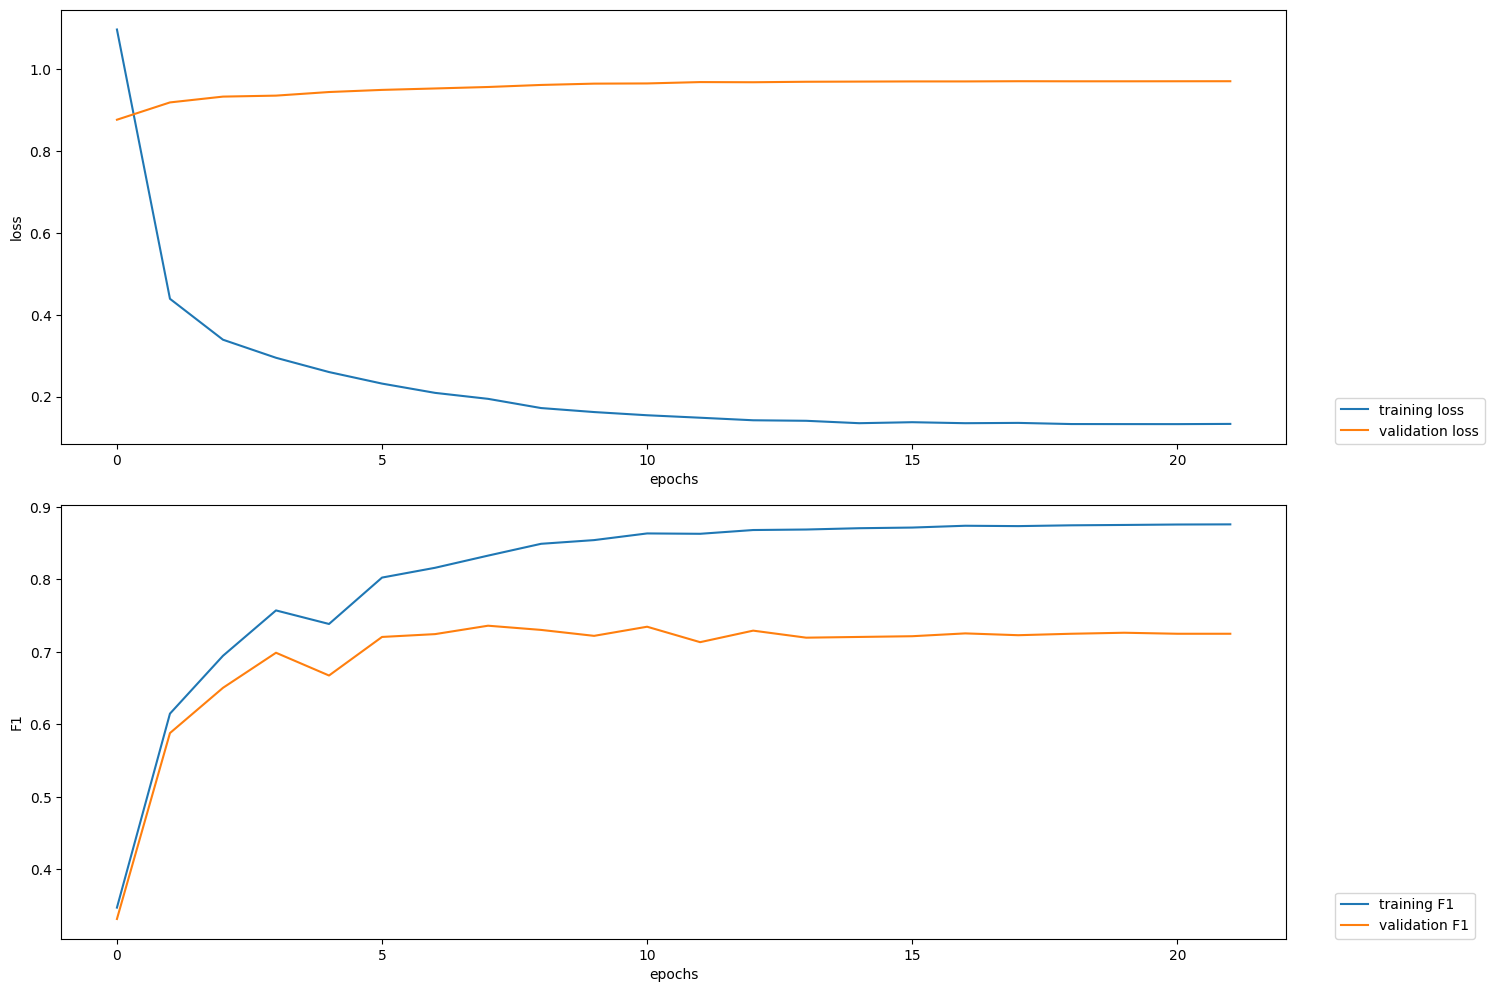

100%|██████████| 79/79 [00:22<00:00,  3.51it/s]

2023-04-21 07:32:20,869 Evaluating as a multi-label problem: True



100%|██████████| 10/10 [00:03<00:00,  3.30it/s]

2023-04-21 07:32:27,770 Evaluating as a multi-label problem: False



100%|██████████| 10/10 [00:03<00:00,  3.12it/s]

2023-04-21 07:32:31,066 Evaluating as a multi-label problem: True


,split,index,I-ADR,E-ADR,B-ADR,S-ADR,S-Drug,E-Finding,B-Disease,B-Finding,...,E-Symptom,S-Symptom,B-Symptom,I-Symptom,I-Drug,I-Disease,micro avg,macro avg,weighted avg,samples avg
0,train,precision,0.747026,0.808019,0.797532,0.813885,0.899291,0.316129,0.369942,0.227273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.780286,0.387789,0.735036,0.133143
1,train,recall,0.860868,0.896748,0.906838,0.808511,0.986003,0.245000,0.537815,0.050000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.802570,0.315768,0.802570,0.133106
2,train,f1-score,0.799916,0.850074,0.848680,0.811189,0.940653,0.276056,0.438356,0.081967,...,0.0,0.0,0.0,0.0,0.0,0.0,0.791271,0.317309,0.761044,0.133119
3,train,support,4449.000000,3506.000000,3349.000000,1363.000000,1286.000000,200.000000,119.000000,200.000000,...,114.0,112.0,110.0,104.0,50.0,50.0,15722.000000,15722.000000,15722.000000,15722.000000
4,dev,precision,0.611801,0.724609,0.722222,0.740566,0.890710,0.363636,0.333333,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.699061,0.440177,0.668244,NaN
5,dev,recall,0.762089,0.826281,0.852941,0.751196,0.993902,0.117647,0.400000,0.102564,...,0.0,0.0,0.0,0.0,0.0,0.0,0.720716,0.277539,0.720716,NaN
6,dev,f1-score,0.678725,0.772112,0.782158,0.745843,0.939481,0.177778,0.363636,0.177778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.709724,0.282199,0.672672,NaN
7,dev,support,517.000000,449.000000,442.000000,209.000000,164.000000,34.000000,15.000000,39.000000,...,13.0,13.0,12.0,23.0,7.0,13.0,2066.000000,2066.000000,2066.000000,NaN
8,test,precision,0.675485,0.783951,0.748414,0.704142,0.857143,0.428571,0.200000,0.142857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.732026,0.330362,0.679839,0.123035
9,test,recall,0.729524,0.861991,0.846890,0.753165,0.968750,0.222222,0.625000,0.041667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.732026,0.300609,0.732026,0.122951


In [18]:
print(suf)

os.mkdir('flair_ner_model'+suf+'/classification_report')
plotter.plot_training_curves('flair_ner_model'+suf+'/loss.tsv')

# evaluate the tagger on the test set
result = tagger.evaluate(corpus.train, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/train.txt', 'w').write(str(result))
res1 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res1.insert(loc=0, column='split', value='train')

result = tagger.evaluate(corpus.dev, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/dev.txt', 'w').write(str(result))
res2 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res2.insert(loc=0, column='split', value='dev')

result = tagger.evaluate(corpus.test, 
                         embeddings_storage_mode='gpu',
                         mini_batch_size=12,
                         main_evaluation_metric = ("weighted avg", "f1-score"),
                         gold_label_type='ner',
                         gold_label_dictionary=tag_dictionary)
open('flair_ner_model'+suf+'/classification_report/test.txt', 'w').write(str(result))
res3 = pd.DataFrame.from_dict(result.classification_report).reset_index()
res3.insert(loc=0, column='split', value='test')

res = pd.concat([res1,res2,res3],ignore_index=True)
res.to_csv('flair_ner_model'+suf+'/classification_report.csv',index=False)
res

In [19]:
# import time
# start_time = time.time()
# while time.time() - start_time < 1:
#     time.sleep(1)
# print('Session has timed out (2 minutes). Disconnecting...')
# !kill -9 -1

Layering can be a good idea if the NER tags in the first layer have their own set of dependent values in the second layer. This can help capture more information about the entities being recognized and provide more context for downstream tasks. However, it also increases the complexity of the annotation and the training process, so it should be used judiciously. In general, it's a good idea to start with a simple tag scheme and gradually increase complexity as needed.

    does it really matter if u use the E header

It depends on the specific task and the requirements of the downstream model. In some cases, using the E tag can help disambiguate between overlapping entities, while in other cases it may not be necessary or even desired. Ultimately, it's up to the developer to determine the appropriate tagging scheme for their specific use case.

    would adding POS as an extra NER layer help model performance or not

Adding POS as an extra NER layer may or may not help model performance, depending on the specific use case and data being analyzed.

On one hand, incorporating POS tags could provide additional context to the model and help it better distinguish between named entities and other parts of speech. For example, knowing that a word is a noun or verb could help the model determine if it is likely to be a named entity or not.

On the other hand, adding an additional layer could also increase model complexity and training time without necessarily improving performance. It may also require additional manual annotation efforts to create a labeled dataset with both NER and POS tags.

Ultimately, whether to include POS as an additional layer will depend on the specific requirements and goals of the project, as well as the available data and resources.

    besides bioes ordering (which is up-to-down), it doesn't matter what order the tags in the same domain appear in left-to-right?

Yes, that is correct. As long as the BIOES order is maintained vertically, the order of tags in the same domain from left-to-right should not impact training in flai

    different typenames must be treated as separate tasks?

Yes, that's correct. Different typenames should be treated as separate tasks because they represent different types of annotations that you want to predict. For example, in a biomedical NER task, you might want to predict the entity types of both drugs and diseases, which would be represented by two different typenames in your annotation data. Predicting both types of entities would require different models and possibly different evaluation metrics.